In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
#import kagglehub
#kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

#store_sales_time_series_forecasting_path = kagglehub.competition_download('store-sales-time-series-forecasting')

#print('Data source import complete.')


In [ ]:
import os

IN_KAGGLE = 'KAGGLE_URL_BASE' in os.environ

if IN_KAGGLE:
    print("Estás en un kernel de Kaggle.")
    # ... código específico para Kaggle ...
    dirname = '/kaggle/input/store-sales-time-series-forecasting'
else:
    print("No estás en un kernel de Kaggle.")
    # CARGA DE DATOS
    from google.colab import files
    # Carga de archivos
    uploaded = files.upload()
    dirname = '/content'

Estás en un kernel de Kaggle.


In [ ]:
print (dirname)

/kaggle/input/store-sales-time-series-forecasting


Paso 1: Configuración Inicial y Carga de Datos

In [ ]:
import pandas as pd
# Carga de datos
print("Cargando datos...")
train = pd.read_csv(dirname + '/'+  'train.csv', parse_dates=['date'])
test =  pd.read_csv(dirname + '/'+  'test.csv', parse_dates=['date'])
stores = pd.read_csv( dirname + '/'+  'stores.csv')
oil =  pd.read_csv(dirname + '/'+  'oil.csv', parse_dates=['date'])
holidays =  pd.read_csv(dirname + '/'+  'holidays_events.csv', parse_dates=['date'])
transactions =  pd.read_csv(dirname + '/'+  'transactions.csv', parse_dates=['date'])
print("Datos Cargados.")



Cargando datos...
Datos Cargados.


 PASO 2. ANÁLISIS EXPLORATORIO DE DATOS (EDA)

In [ ]:
# Configuración inicial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import lightgbm as lgb
from sklearn.model_selection import KFold


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 50)



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


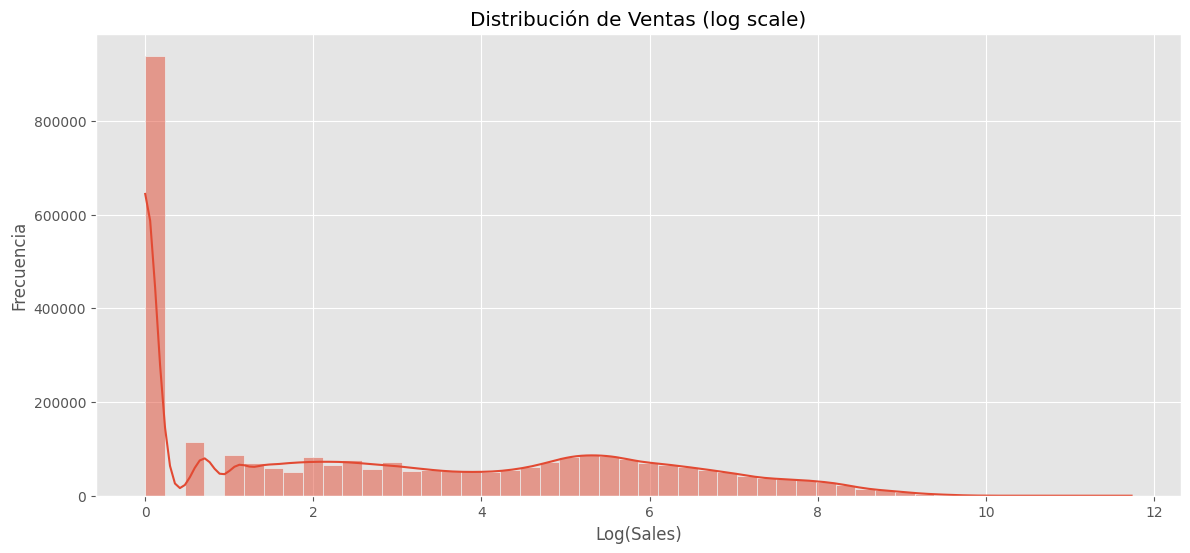

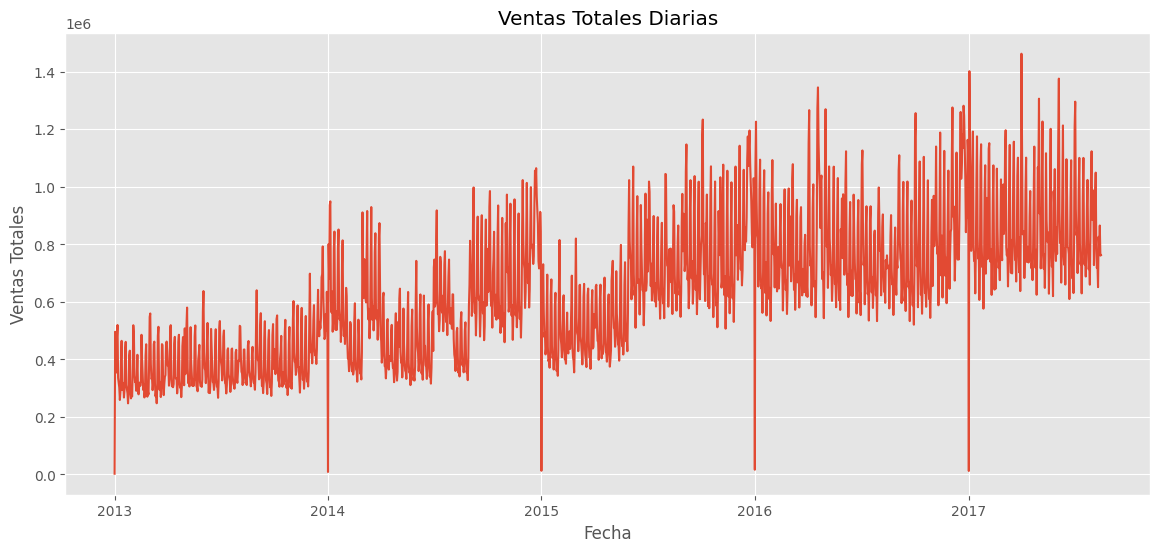

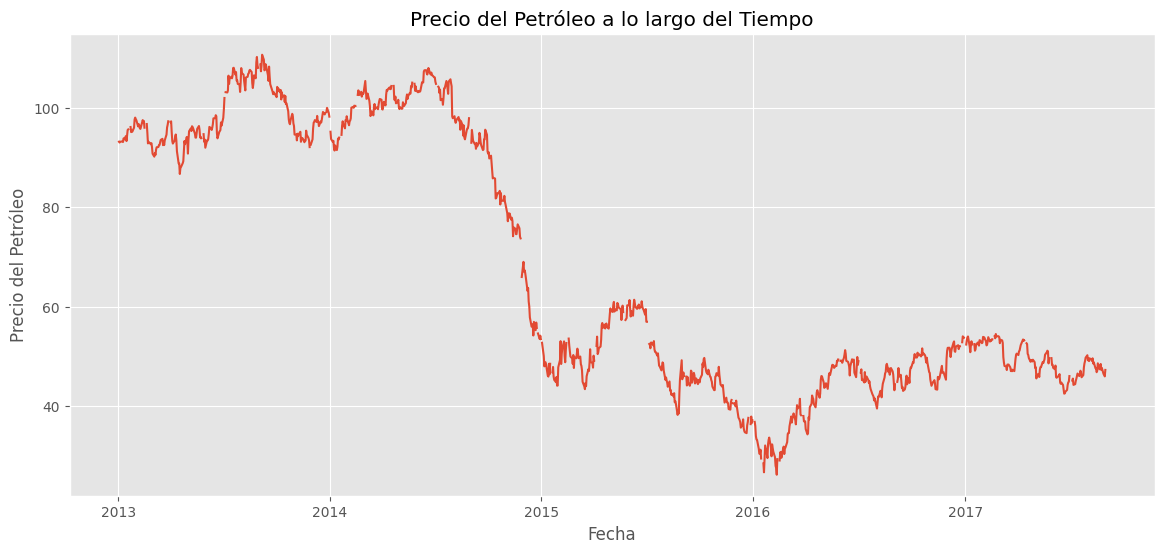

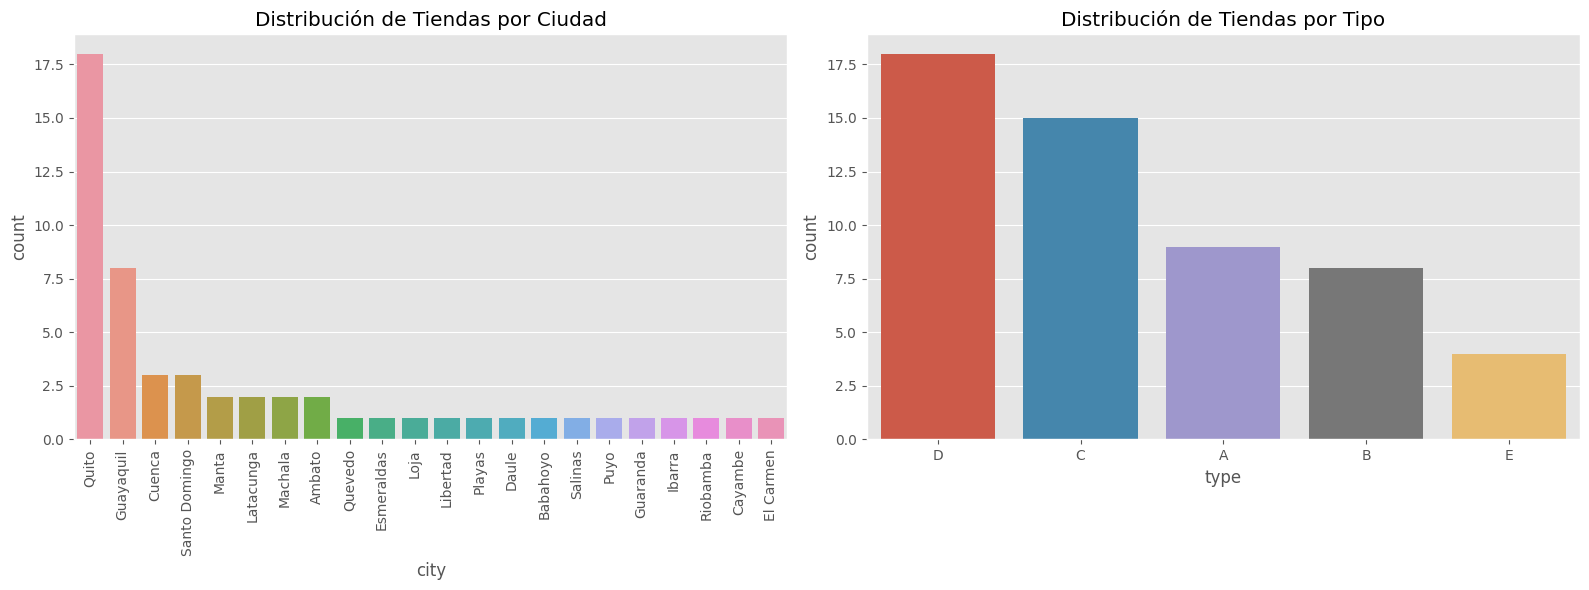

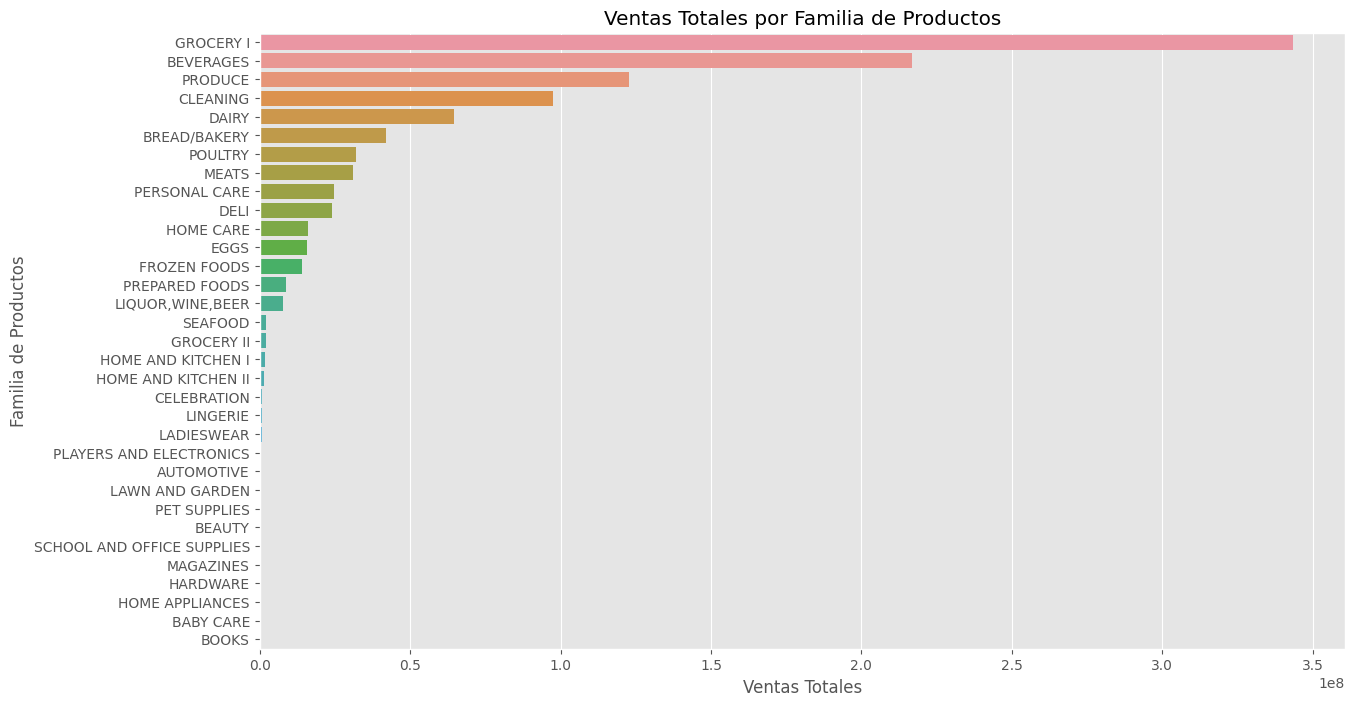

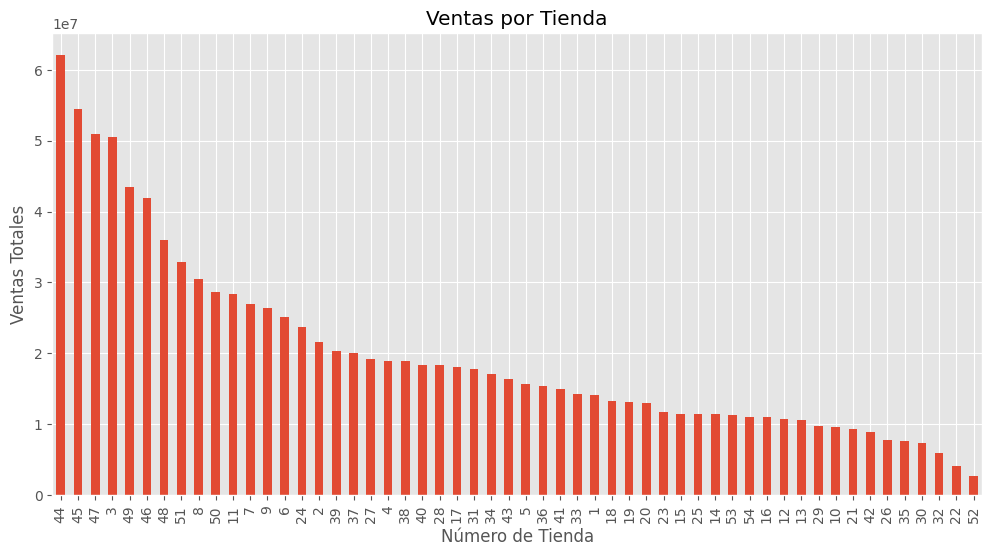

In [ ]:
# 1. Distribución de ventas
plt.figure(figsize=(14, 6))
sns.histplot(np.log1p(train['sales']), bins=50, kde=True)
plt.title('Distribución de Ventas (log scale)')
plt.xlabel('Log(Sales)')
plt.ylabel('Frecuencia')
plt.show()



# 2. Ventas a lo largo del tiempo
daily_sales = train.groupby('date')['sales'].sum().reset_index()
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Ventas Totales Diarias')
plt.xlabel('Fecha')
plt.ylabel('Ventas Totales')
plt.grid(True)
plt.show()

# 3. Precio del petróleo
plt.figure(figsize=(14, 6))
plt.plot(oil['date'], oil['dcoilwtico'])
plt.title('Precio del Petróleo a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio del Petróleo')
plt.grid(True)
plt.show()



# 4. Distribución de tiendas por ciudad y tipo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=stores, x='city', ax=axes[0], order=stores['city'].value_counts().index)
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('Distribución de Tiendas por Ciudad')

sns.countplot(data=stores, x='type', ax=axes[1], order=stores['type'].value_counts().index)
axes[1].set_title('Distribución de Tiendas por Tipo')
plt.tight_layout()
plt.show()


# 5. Ventas por familia de productos
family_sales = train.groupby('family')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
sns.barplot(x=family_sales.values, y=family_sales.index)
plt.title('Ventas Totales por Familia de Productos')
plt.xlabel('Ventas Totales')
plt.ylabel('Familia de Productos')
plt.show()


# 6. Análisis por tienda
store_sales = train.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
store_sales.plot(kind='bar')
plt.title('Ventas por Tienda')
plt.xlabel('Número de Tienda')
plt.ylabel('Ventas Totales')
plt.show()


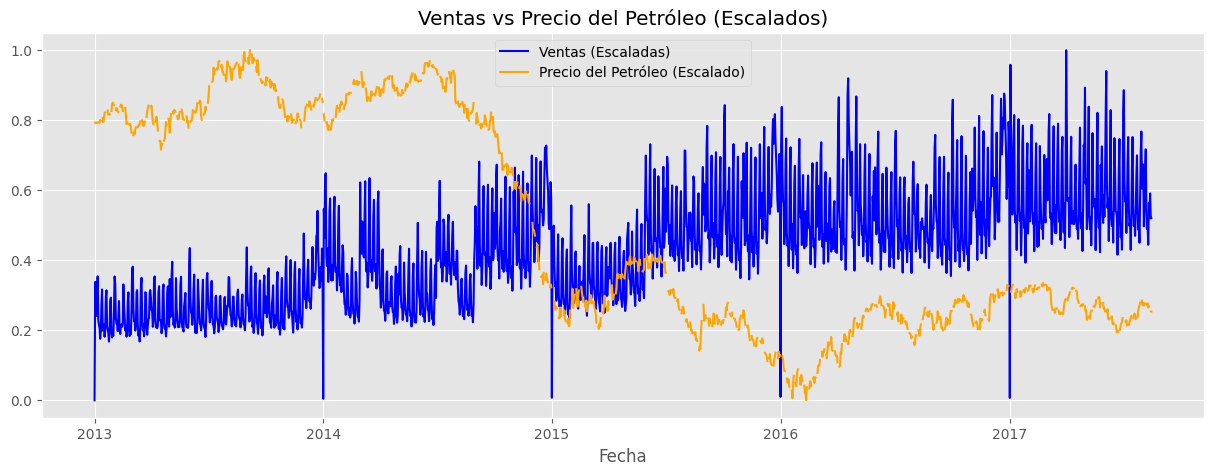

In [ ]:
# tendencias temporales... cómo evolucionan las ventas en el tiempo, para saber si hay algún patrón o anomalía en la serie temporal
train_grouped = train.groupby("date")["sales"].sum().reset_index()

merged = train_grouped.merge(oil, on="date", how="left")
#la grafica no era comparable, asi que extraemos una muestra
merged_sample = merged.sample(n=1000, random_state=42)

# Impacto del Precio del Petróleo con escalado para comparabilidad
from sklearn.preprocessing import MinMaxScaler
# para ver si hay correlación entre el precio del petróleo y las ventas, Si la hay la podemos usar  como feature en el modelo.
merged = train_grouped.merge(oil, on="date", how="left")

# Obtener una muestra aleatoria de 1000 registros
merged_sample = merged.sample(n=1000, random_state=42)  # random_state para reproducibilidad

# Escalar las columnas
scaler = MinMaxScaler()
merged[['sales_scaled', 'dcoilwtico_scaled']] = scaler.fit_transform(merged[['sales', 'dcoilwtico']])
# Graficar los datos escalados
plt.figure(figsize=(15, 5))
plt.plot(merged["date"], merged["sales_scaled"], label="Ventas (Escaladas)", color="blue")
plt.plot(merged["date"], merged["dcoilwtico_scaled"], label="Precio del Petróleo (Escalado)", color="orange")
plt.xlabel("Fecha")
plt.title("Ventas vs Precio del Petróleo (Escalados)")
plt.legend()
plt.show()


In [ ]:
#MUCHOS DATOS,  no termina de procsar. EN lugar se  MOSTRARAN POR FAMILIA
# 7. Calcular efecto de promociones

# Calcular efecto de promociones
#promo_effect = train.groupby('onpromotion')['sales'].mean().reset_index()
#promo_effect['Estado'] = promo_effect['onpromotion'].map({0: 'No Promoción', 1: 'Con Promoción'})

# Crear figura
#fig, ax = plt.subplots(figsize=(10, 6))

# Usar hue explícitamente para eliminar el warning
#sns.barplot(data=promo_effect, x='Estado', y='sales', hue='Estado', palette='viridis', ax=ax, legend=False)

# Títulos y etiquetas
#ax.set_title('Efecto de Promociones en Ventas Promedio', fontsize=16)
#ax.set_xlabel('Estado de Promoción', fontsize=13)
#ax.set_ylabel('Ventas Promedio', fontsize=13)

# Mostrar valores sobre las barras
#for i, row in promo_effect.iterrows():
#    ax.text(i, row['sales'] * 1.03, f"{row['sales']:.0f}", ha='center', fontsize=12)

#ax.grid(axis='y', linestyle='--', alpha=0.6)

#plt.show()




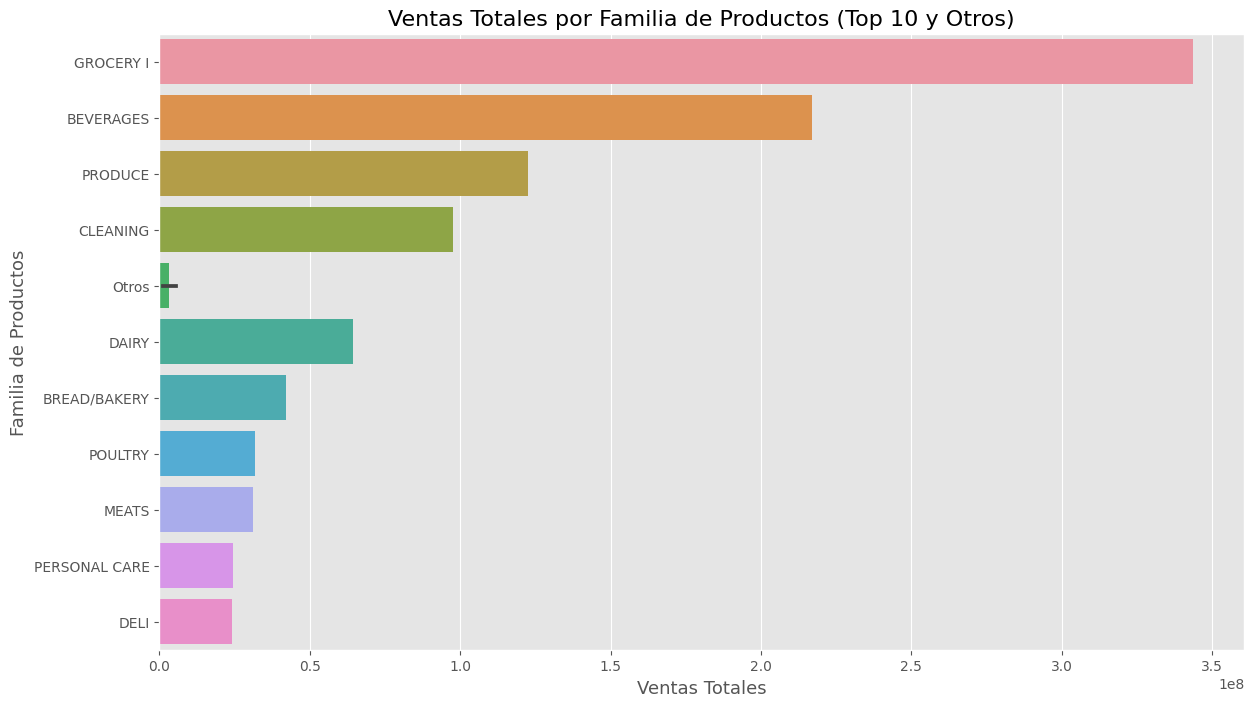

In [ ]:
#MUCHOS DATOS,  no termina de procsar. EN lugar se  MOSTRARAN POR FAMILIA
# 7. Calcular efecto de promociones,  Ventas por familia de productos

# Calcular ventas por familia
family_sales = train.groupby('family')['sales'].sum().sort_values(ascending=False)

# Identificar las top 10 familias
top_n = 10
top_families = family_sales.head(top_n).index.tolist()

# Crear una nueva columna agrupada en el DataFrame original
temp_df = train.groupby('family')['sales'].sum().reset_index()
temp_df['family_grouped'] = temp_df['family'].apply(lambda x: x if x in top_families else 'Otros')

# Crear el gráfico usando la nueva columna agrupada para el eje X

plt.figure(figsize=(14, 8))
# Usamos el DataFrame agrupado temporal
sns.barplot(x=temp_df['sales'], y=temp_df['family_grouped'], order=temp_df.groupby('family_grouped')['sales'].sum().sort_values(ascending=False).index)
plt.title('Ventas Totales por Familia de Productos (Top 10 y Otros)', fontsize=16)
plt.xlabel('Ventas Totales', fontsize=13)
plt.ylabel('Familia de Productos', fontsize=13)
plt.show()




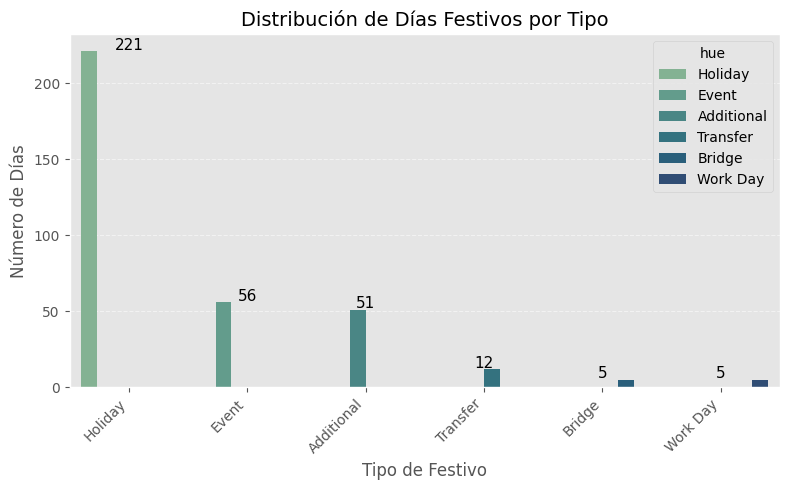

In [ ]:
# 8. Distribución de Días Festivos por Tipo
# Calcular conteo de festivos por tipo
holiday_counts = holidays['type'].value_counts().reset_index()
holiday_counts.columns = ['Tipo', 'Cantidad']
# Para evitar el warning, duplicamos la columna 'Tipo' como 'hue'
holiday_counts['hue'] = holiday_counts['Tipo']

plt.figure(figsize=(8, 5))
sns.barplot(data=holiday_counts, x='Tipo', y='Cantidad', palette='crest', hue='hue')
plt.title('Distribución de Días Festivos por Tipo', fontsize=14)
plt.xlabel('Tipo de Festivo', fontsize=12)
plt.ylabel('Número de Días', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, row in holiday_counts.iterrows():
    plt.text(i, row['Cantidad'] + 1, int(row['Cantidad']), ha='center', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


PASO 3. PREPROCESAMIENTO Y LIMPIEZA

In [ ]:
# 1. Manejo de valores faltantes en el precio del petróleo
oil['dcoilwtico'] = pd.to_numeric(oil['dcoilwtico'], errors='coerce')
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate().ffill()
#oil['dcoilwtico'] = oil['dcoilwtico'].interpolate().fillna(method='ffill').fillna(method='bfill')

# 2. Procesamiento de festivos
holidays['is_holiday'] = np.where(
    ((holidays['type'] == 'Holiday') & (~holidays['transferred'])) |
    (holidays['type'] == 'Transfer') |
    (holidays['type'].isin(['Bridge', 'Additional'])),
    1, 0
)

# Festivos nacionales
national = holidays[(holidays['is_holiday'] == 1) &
                   (holidays['locale'] == 'National')][['date']].drop_duplicates()
national['national_holiday'] = 1

# Festivos regionales
regional = holidays[(holidays['is_holiday'] == 1) &
                   (holidays['locale'] == 'Regional')]
regional = regional.merge(stores[['store_nbr', 'state']],
                         left_on='locale_name', right_on='state')[['date', 'store_nbr']].drop_duplicates()
regional['regional_holiday'] = 1

# Festivos locales
local = holidays[(holidays['is_holiday'] == 1) &
                (holidays['locale'] == 'Local')]
local = local.merge(stores[['store_nbr', 'city']],
                   left_on='locale_name', right_on='city')[['date', 'store_nbr']].drop_duplicates()
local['local_holiday'] = 1

# Combinar festivos con los datos de entrenamiento y prueba
train = train.merge(national, on='date', how='left')
train = train.merge(regional, on=['date', 'store_nbr'], how='left')
train = train.merge(local, on=['date', 'store_nbr'], how='left')

test = test.merge(national, on='date', how='left')
test = test.merge(regional, on=['date', 'store_nbr'], how='left')
test = test.merge(local, on=['date', 'store_nbr'], how='left')

for col in ['national_holiday', 'regional_holiday', 'local_holiday']:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

# 3. Combinar datos de petróleo
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')

# 4. Manejo de valores faltantes después del merge
train["dcoilwtico"] = train["dcoilwtico"].interpolate().ffill()
test["dcoilwtico"] = test["dcoilwtico"].interpolate().ffill()


# 5. Combinar datos de tiendas
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')





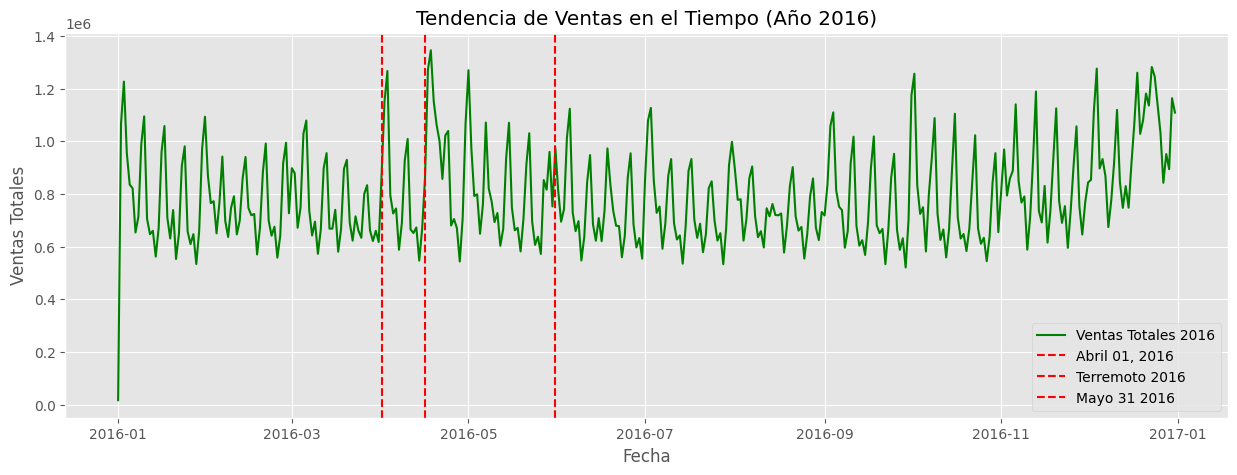

In [ ]:
# 2016  por mes, en los meses ABRIL Y MAYO

train_2016 = train[train["date"].dt.year == 2016]

train_grouped_2016 = train_2016.groupby("date")["sales"].sum().reset_index()

plt.figure(figsize=(15, 5))
plt.plot(train_grouped_2016["date"], train_grouped_2016["sales"], label="Ventas Totales 2016", color="green")
plt.axvline(pd.Timestamp("2016-04-01"), color="r", linestyle="--", label="Abril 01, 2016")
plt.axvline(pd.Timestamp("2016-04-16"), color="r", linestyle="--", label="Terremoto 2016")
plt.axvline(pd.Timestamp("2016-05-31"), color="r", linestyle="--", label="Mayo 31 2016")
plt.xlabel("Fecha")
plt.ylabel("Ventas Totales")
plt.title("Tendencia de Ventas en el Tiempo (Año 2016)")
plt.legend()
plt.show()

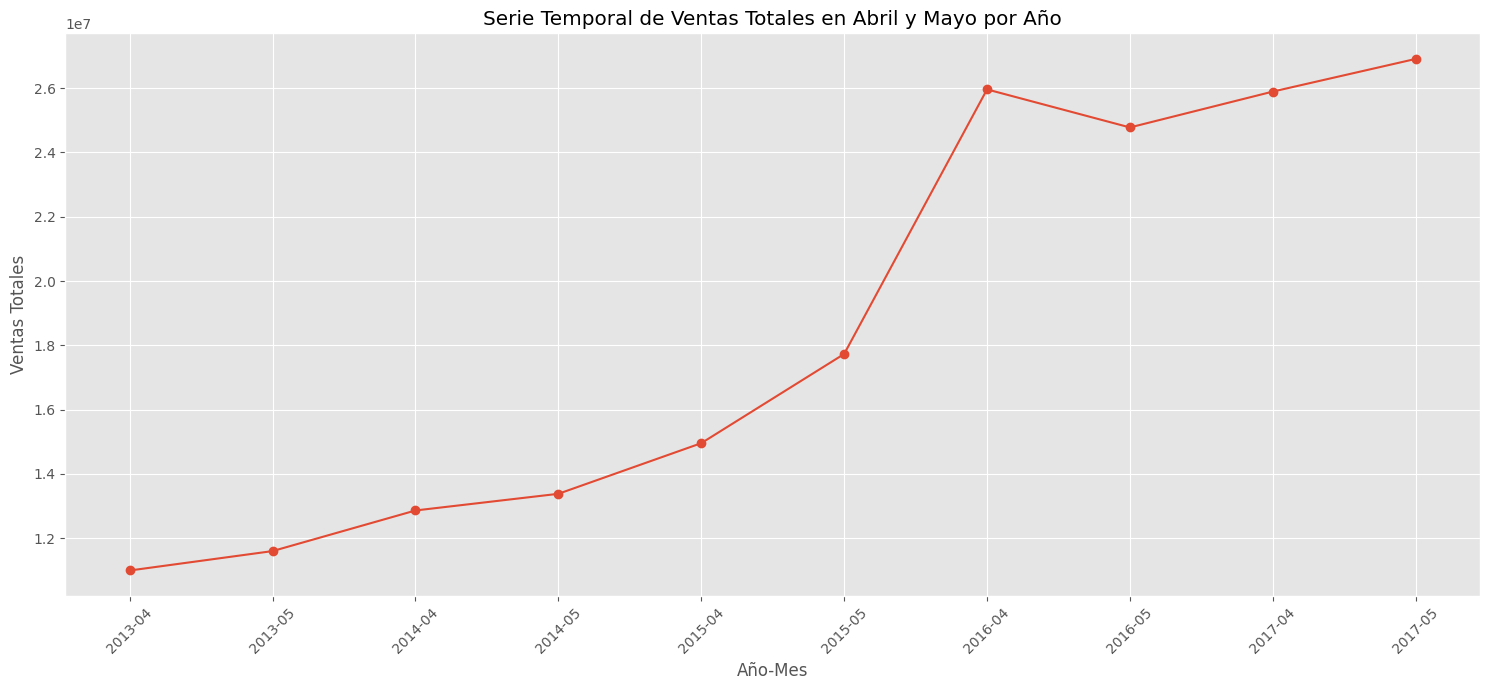

In [ ]:
# filtramos abril y mayo
train_april_may = train[train["date"].dt.month.isin([4, 5])].copy()

# encesitamos mes y año para agrupar
train_april_may['year'] = train_april_may['date'].dt.year
train_april_may['month'] = train_april_may['date'].dt.month
train_grouped_april_may = train_april_may.groupby(['year', 'month'])['sales'].sum().reset_index()

# Ordenamos los  datos por año y mes para creta la serie que nos interesa
train_grouped_april_may = train_grouped_april_may.sort_values(by=['year', 'month'])

train_grouped_april_may['year_month'] = train_grouped_april_may['year'].astype(str) + '-' + train_grouped_april_may['month'].astype(str).str.zfill(2)


# Graficamos
plt.figure(figsize=(15, 7))
plt.plot(train_grouped_april_may['year_month'], train_grouped_april_may['sales'], marker='o', linestyle='-')

plt.xlabel("Año-Mes")
plt.ylabel("Ventas Totales")
plt.title("Serie Temporal de Ventas Totales en Abril y Mayo por Año")
plt.xticks(rotation=45) # para mejor lectura
plt.grid(True)
plt.tight_layout()
plt.show()

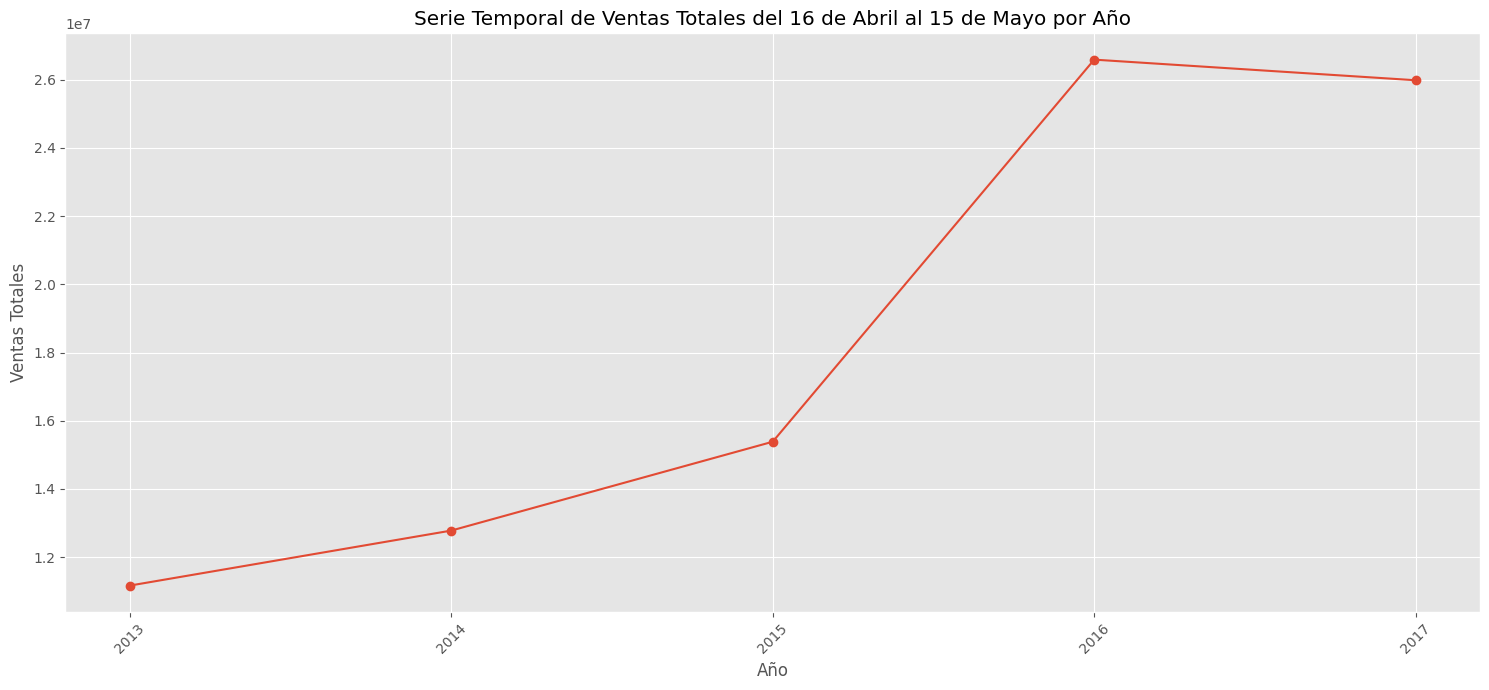

In [ ]:
# Filtramos el período del 16 de abril al 15 de mayo, para estar seguro que los dias previos de abril y finales de mayo no estan inluenciando la grafica previa
# Usamos .dt.day para el día y .dt.month para el mes
train_earthquake_period = train[
    (
        ((train['date'].dt.month == 4) & (train['date'].dt.day >= 16)) | # Desde el 16 de abril
        ((train['date'].dt.month == 5) & (train['date'].dt.day <= 15))    # Hasta el 15 de mayo
    )
].copy()

# Necesitamos año para agrupar
train_earthquake_period['year'] = train_earthquake_period['date'].dt.year

# Agrupamos por año y sumamos las ventas
train_grouped_earthquake_period = train_earthquake_period.groupby('year')['sales'].sum().reset_index()

# Ordenamos los datos por año para crear la serie
train_grouped_earthquake_period = train_grouped_earthquake_period.sort_values(by='year')

# Convertimos el año a string para el eje X del gráfico
train_grouped_earthquake_period['year_str'] = train_grouped_earthquake_period['year'].astype(str)

# Graficamos
plt.figure(figsize=(15, 7))
plt.plot(train_grouped_earthquake_period['year_str'], train_grouped_earthquake_period['sales'], marker='o', linestyle='-')

plt.xlabel("Año")
plt.ylabel("Ventas Totales")
plt.title("Serie Temporal de Ventas Totales del 16 de Abril al 15 de Mayo por Año")
plt.xticks(rotation=45) # para mejor lectura
plt.grid(True)
plt.tight_layout()
plt.show()

 PASO 4. INGENIERÍA DE CARACTERÍSTICAS

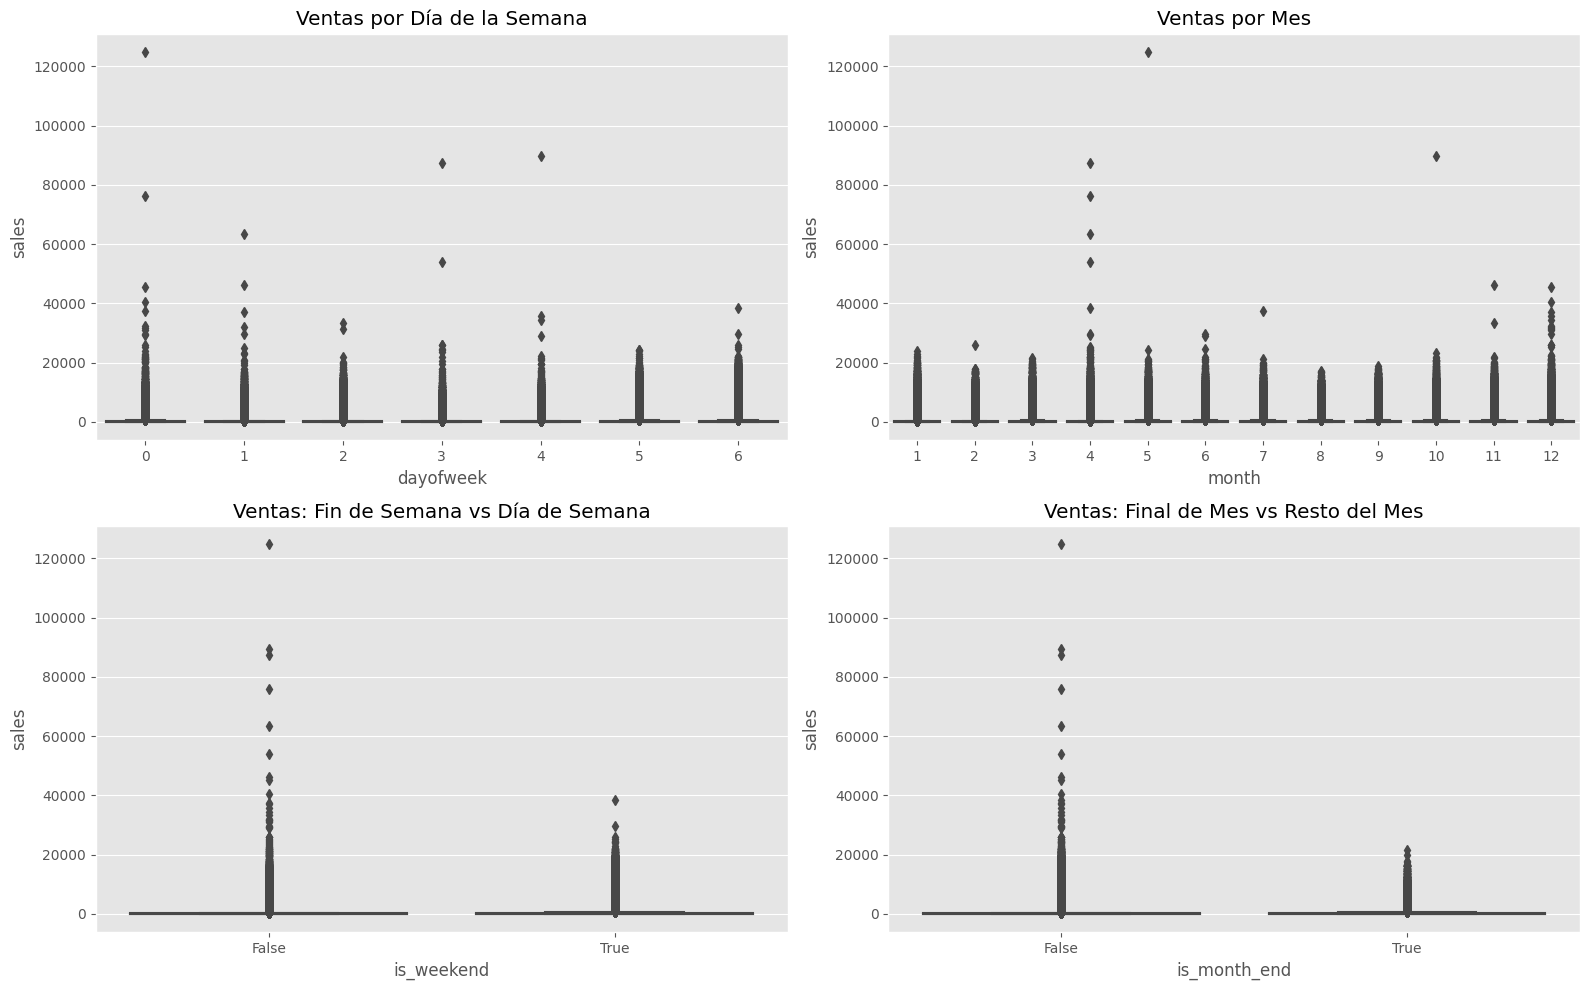

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

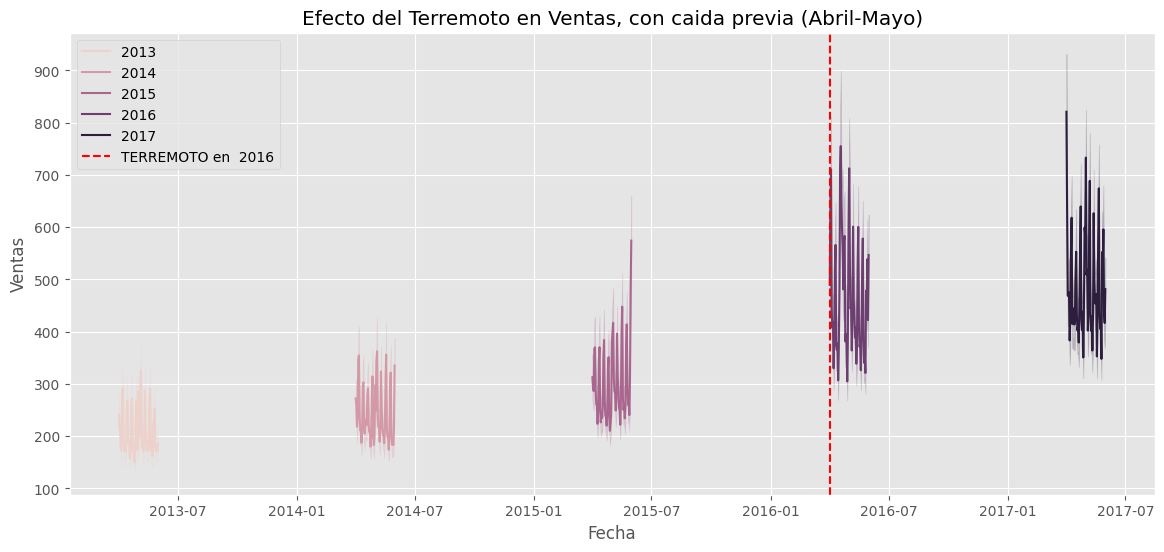

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

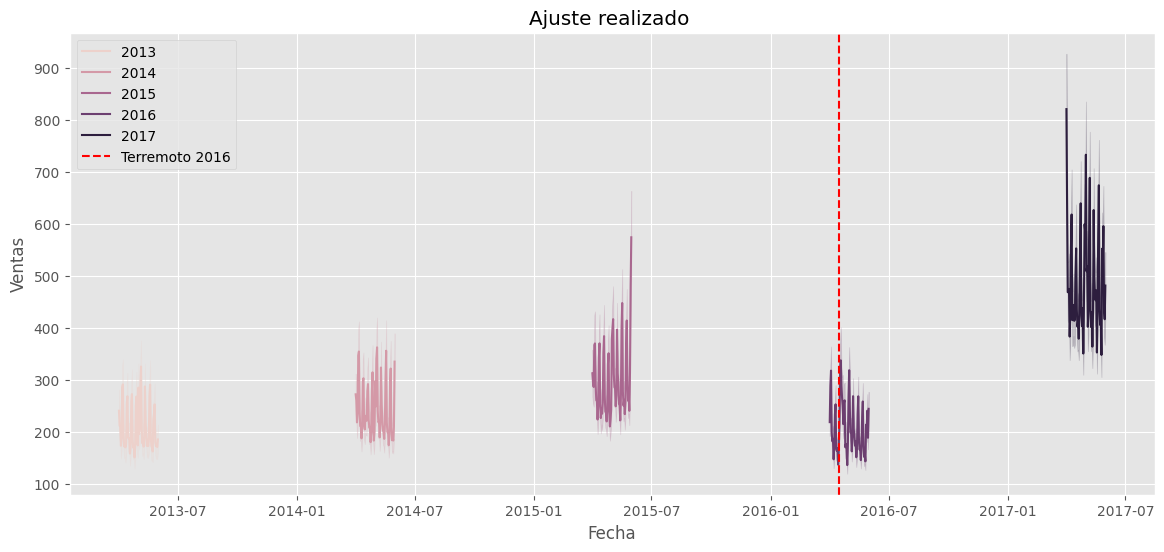

In [ ]:
# 1. Características temporales
for df in [train, test]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'] >= 5
    df['is_month_end'] = df['date'].dt.is_month_end
    df['is_month_start'] = df['date'].dt.is_month_start
    df['is_wage_day'] = (df['day'] == 15) | df['is_month_end']
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['is_earthquake_period'] = 0 # Inicializar a 0
    # Aplicar la condición de filtrado para el período del 16 de abril al 15 de mayo de 2016
    df.loc[
        (df['date'].dt.year == 2016) &
        (
            ((df['date'].dt.month == 4) & (df['date'].dt.day >= 16)) | # Desde el 16 de abril de 2016
            ((df['date'].dt.month == 5) & (df['date'].dt.day <= 15))    # Hasta el 15 de mayo de 2016
        ),
        'is_earthquake_period'
    ] = 1



# Visualización de características temporales
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.boxplot(data=train, x='dayofweek', y='sales', ax=axes[0, 0])
axes[0, 0].set_title('Ventas por Día de la Semana')

sns.boxplot(data=train, x='month', y='sales', ax=axes[0, 1])
axes[0, 1].set_title('Ventas por Mes')

sns.boxplot(data=train, x='is_weekend', y='sales', ax=axes[1, 0])
axes[1, 0].set_title('Ventas: Fin de Semana vs Día de Semana')

sns.boxplot(data=train, x='is_month_end', y='sales', ax=axes[1, 1])
axes[1, 1].set_title('Ventas: Final de Mes vs Resto del Mes')
plt.tight_layout()
plt.show()

# 2. Codificación de variables categóricas
from sklearn.preprocessing import LabelEncoder

cat_cols = ['family', 'city', 'state', 'type', 'cluster']
for col in cat_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train[col], test[col]]))
    train[f'{col}_enc'] = le.transform(train[col])
    test[f'{col}_enc'] = le.transform(test[col])

# 3. Promedios móviles
last_date = train['date'].max()
for days in [7, 14, 30]:
    train_last = train[train['date'] > (last_date - pd.DateOffset(days=days))]
    avg = train_last.groupby(['store_nbr', 'family'])['sales'].mean().reset_index()
    avg.rename(columns={'sales': f'avg_{days}d'}, inplace=True)
    train = train.merge(avg, on=['store_nbr', 'family'], how='left')
    test = test.merge(avg, on=['store_nbr', 'family'], how='left')

# 4. Ajuste por terremoto (abril-mayo 2016)

# Visualización del efecto del terremoto y caida previa
earthquake_data = train[(train['date'].dt.month.isin([4, 5]))]
plt.figure(figsize=(14, 6))
sns.lineplot(data=earthquake_data, x='date', y='sales', hue=earthquake_data['date'].dt.year)
plt.axvline(pd.to_datetime('2016-04-01'), color='red', linestyle='--', label='TERREMOTO en  2016')
plt.title('Efecto del Terremoto en Ventas, con caida previa (Abril-Mayo)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

train['log_sales'] = np.log1p(train['sales'])
april_may_log_sales_other_years = train[
    (train['date'].dt.month.isin([4, 5])) & (train['date'].dt.year != 2016)
]['log_sales'].mean()
april_may_log_sales_2016 = train[
    (train['date'].dt.month.isin([4, 5])) & (train['date'].dt.year == 2016)
]['log_sales'].mean()
correction_factor_log = april_may_log_sales_other_years - april_may_log_sales_2016

train.loc[
    (train['date'].dt.month.isin([4, 5])) & (train['date'].dt.year == 2016),
    'log_sales',
] += correction_factor_log
train['sales'] = np.expm1(train['log_sales'])
train.drop(columns=['log_sales'], inplace=True)


# Visualización del efecto del terremoto
earthquake_data = train[(train['date'].dt.month.isin([4, 5]))]
plt.figure(figsize=(14, 6))
sns.lineplot(data=earthquake_data, x='date', y='sales', hue=earthquake_data['date'].dt.year)
plt.axvline(pd.to_datetime('2016-04-16'), color='red', linestyle='--', label='Terremoto 2016')
plt.title('Ajuste realizado ')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()


# 5. Proporción de promociones
def calcular_proporcion_promocion(df):
    filtered_df = df[df['onpromotion'] > 0]
    promo_by_store_month = filtered_df.groupby(['store_nbr', 'month', 'onpromotion'])['id'].count().reset_index()
    promo_by_store_month['proportion'] = promo_by_store_month.groupby(['store_nbr', 'month'])['id'].transform(lambda x: x / x.sum())
    df = df.merge(promo_by_store_month[['store_nbr', 'month', 'onpromotion', 'proportion']],
                   on=['store_nbr', 'month', 'onpromotion'], how='left')
    df['proportion'] = 0
    df['proportion'] = df['proportion'].fillna(0)
    return df


train = calcular_proporcion_promocion(train)
test['proportion'] = 0



 PASO 5. MODELADO Y EVALUACIÓN

Training until validation scores don't improve for 50 rounds
[50]	cv_agg's valid rmsle: 0.430859 + 0.0582198
[100]	cv_agg's valid rmsle: 0.42764 + 0.0612486
Early stopping, best iteration is:
[70]	cv_agg's valid rmsle: 0.426354 + 0.0600387
Mejor número de rondas de boosting: 70
RMSLE promedio: 0.426354
RMSLE en validación final: 0.514951


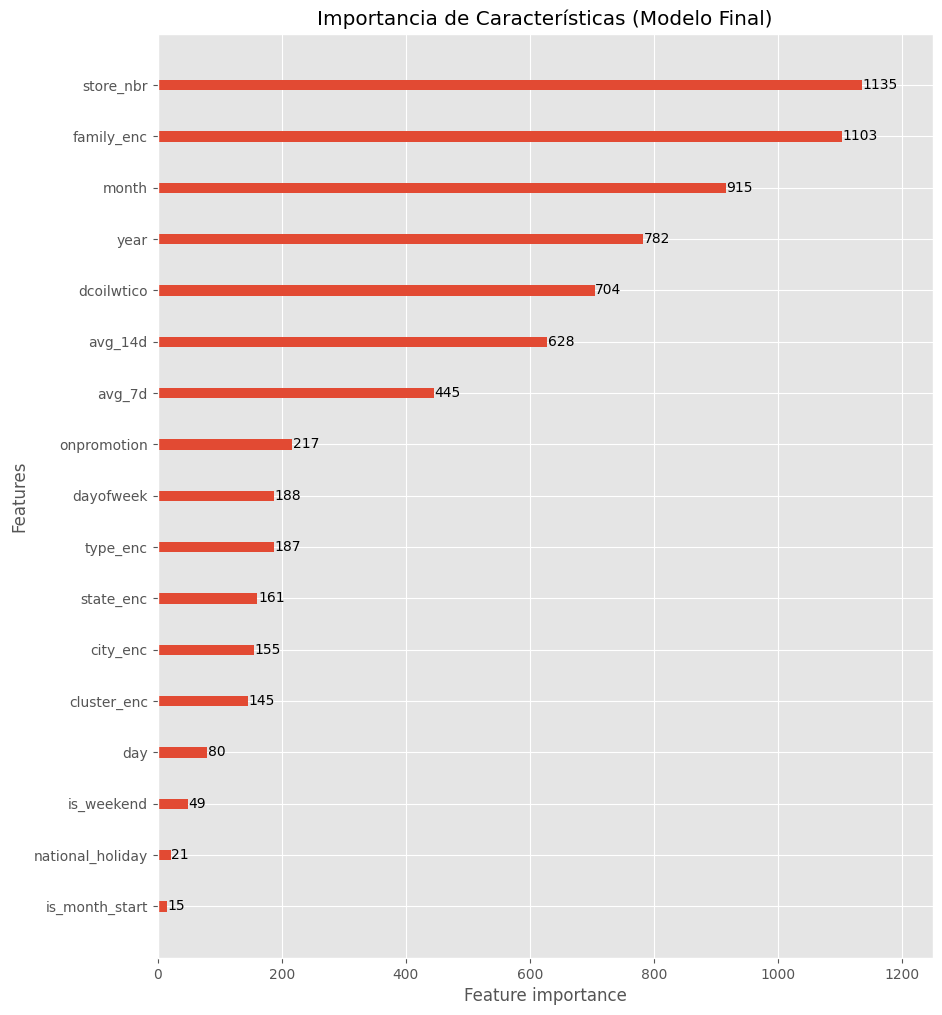

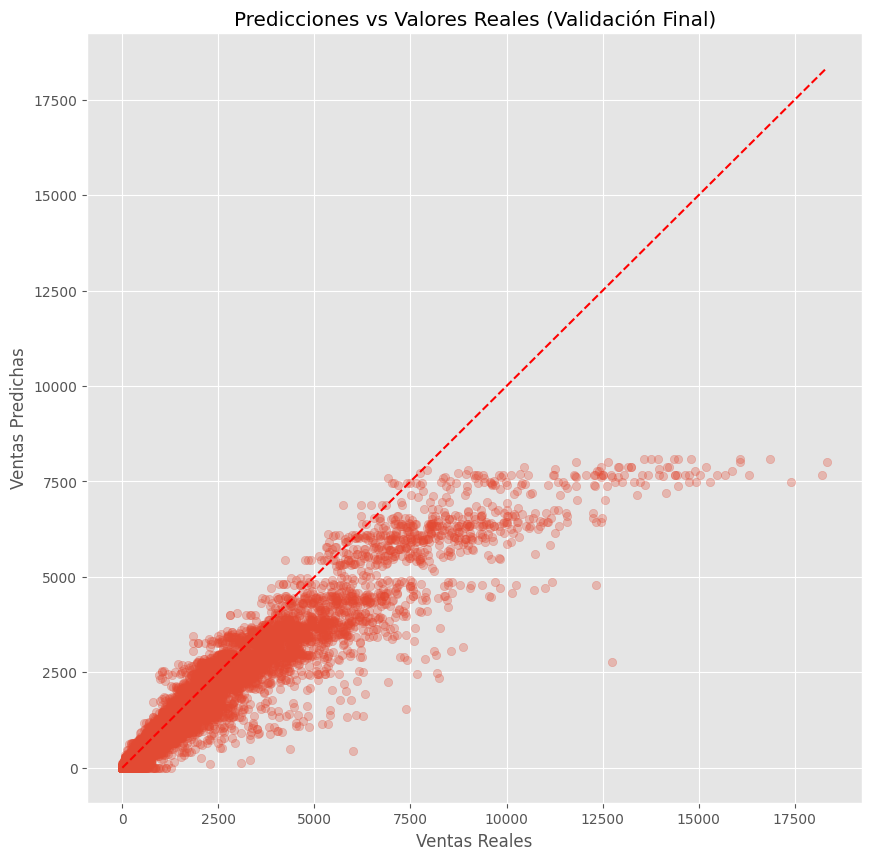

¡Proceso completado con TimeSeriesSplit y RMSLE en CV!


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Definir función RMSLE para LightGBM
def rmsle_lgb(preds, train_data):
    y_true = train_data.get_label()
    y_pred = np.clip(preds, 0, None)  # Evitar negativos
    return 'rmsle', np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2)), False

# 2. Configurar parámetros con métrica personalizada
params = {
    'objective': 'regression',
    'metric': 'custom',  # Usaremos nuestra métrica personalizada
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': -1
}

# 3. Preparar datos (igual que antes)
features = [
    'store_nbr', 'family_enc', 'onpromotion', 'national_holiday',
    'regional_holiday', 'local_holiday', 'dcoilwtico', 'year', 'month',
    'day', 'dayofweek', 'is_weekend', 'is_month_start', 'is_month_end',
    'is_wage_day', 'city_enc', 'state_enc', 'type_enc', 'cluster_enc',
    'avg_7d', 'avg_14d', 'proportion'
]

X_train = train[train['date'] < '2017-07-15'][features]
y_train = np.log1p(train[train['date'] < '2017-07-15']['sales'])
X_val = train[train['date'] >= '2017-07-15'][features]
y_val = np.log1p(train[train['date'] >= '2017-07-15']['sales'])

# 4. Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# 5. Validación cruzada con TimeSeriesSplit y RMSLE
dtrain = lgb.Dataset(X_train, label=y_train)

cv_results = lgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    folds=tscv.split(X_train),
    feval=rmsle_lgb,  # Usamos nuestra función RMSLE
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50),
        lgb.record_evaluation({'rmsle': rmsle_lgb})
    ]
)

best_num_boost_round = len(cv_results['valid rmsle-mean'])
mean_rmsle = cv_results['valid rmsle-mean'][-1]
print(f"Mejor número de rondas de boosting: {best_num_boost_round}")
print(f"RMSLE promedio: {mean_rmsle:.6f}")

# 6. Entrenar modelo final con todos los datos
full_train = pd.concat([X_train, X_val])
full_y = pd.concat([y_train, y_val])

final_model = lgb.train(
    params,
    lgb.Dataset(full_train, label=full_y),
    num_boost_round=best_num_boost_round,
    feval=rmsle_lgb  # Mantener consistencia en la métrica
)

# 7. Evaluar en validation set para comparación
val_pred = np.expm1(final_model.predict(X_val))
y_val_original = np.expm1(y_val)

def rmsle(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred = np.clip(y_pred, 0, None)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

score = rmsle(y_val_original, val_pred)
print(f"RMSLE en validación final: {score:.6f}")

# 8. Generar predicciones para test
test['sales'] = np.expm1(final_model.predict(test[features]))

# 9. Guardar resultados
submission = test[['id', 'sales']]
submission.to_csv('submission_final_PROY2.csv', index=False)

# 10. Visualizaciones
lgb.plot_importance(final_model, figsize=(10, 12), max_num_features=20)
plt.title('Importancia de Características (Modelo Final)')
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(y_val_original, val_pred, alpha=0.3)
plt.plot([0, y_val_original.max()], [0, y_val_original.max()], '--r')
plt.title('Predicciones vs Valores Reales (Validación Final)')
plt.xlabel('Ventas Reales')
plt.ylabel('Ventas Predichas')
plt.grid(True)
plt.show()

print("¡Proceso completado con TimeSeriesSplit y RMSLE en CV!")